In [ ]:
import glob
import os
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt

try:
    sys.path.append(glob.glob('../carla/dist/carla-*%d.%d-%s.egg' % (
        sys.version_info.major,
        sys.version_info.minor,
        'win-amd64' if os.name == 'nt' else 'linux-x86_64'))[0])
except IndexError:
    pass

import carla

import random
import time

import yaml
import queue

class Scene:

    def __init__(self, traffic_level=20) -> None:
        
        self._set_world()
        # The world contains the list blueprints that we can use for adding new
        # actors into the simulation.
        # Synchronous mode
        settings = self.world.get_settings()
        settings.synchronous_mode = True
        settings.fixed_delta_seconds = 1/20
        self.world.apply_settings(settings)
        
        self.spawn_points = self.world.get_map().get_spawn_points()
        self.blueprint_lib = self.world.get_blueprint_library()
        self.spectator = self.world.get_spectator()
        self._set_ego_vehicle()
        self._spawn_cars(traffic_level)
        self._set_rgb_camera()
        self.ego_vehicle.set_autopilot(True)
        self._stream_rgb_camera()
        self._destroy_actors()
        
        

    def _set_world(self):
        self.client = carla.Client('localhost', 2000)
        self.client.set_timeout(3.0)

        # Once we have a client we can retrieve the world that is currently
        # running.
        self.world = self.client.get_world()

    def _destroy_actors(self):
        print('aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa')
        for actor in self.world.get_actors().filter('*vehicle*'):
            actor.destroy()
        for actor in self.world.get_actors().filter('*sensor*'):
            actor.destroy()
        
    def _set_ego_vehicle(self, vehicle='tesla.model3'):
        self.vehicles_bp = self.blueprint_lib.find(f'vehicle.{vehicle}')
        self.ego_vehicle = self.world.try_spawn_actor(self.vehicles_bp, random.choice(self.spawn_points))
        self.spectator = self.world.get_spectator() 
        transform = carla.Transform(self.ego_vehicle.get_transform().transform(carla.Location(x=-4,z=2.5)),self.ego_vehicle.get_transform().rotation) 
        self.spectator.set_transform(transform)

    def _spawn_cars(self, num_cars):
        
        random.seed(0)

        if num_cars>len(self.spawn_points):
            print('more cars then spawn points')
            num_cars = len(self.spawn_points) - 1

        else:
            self.spawn_points = self.spawn_points[:num_cars]


        # Select some models from the blueprint library
        models = ['dodge', 'audi', 'model3', 'mini', 'mustang', 'lincoln', 'prius', 'nissan', 'crown', 'impala']
        blueprints = []
        for vehicle in self.world.get_blueprint_library().filter('*vehicle*'):
            if any(model in vehicle.id for model in models):
                blueprints.append(vehicle)

        self.vehicles = []

        # Take a random sample of the spawn points and spawn some vehicles
        for i, spawn_point in enumerate(random.sample(self.spawn_points, num_cars)):
            temp = self.world.try_spawn_actor(random.choice(blueprints), spawn_point)
            if temp is not None:
                self.vehicles.append(temp)
                temp.set_autopilot(True)

    def _read_camera_setup(self):
        pass

    def _set_rgb_camera(self):
        # Set initial camera translation
        camera_init_trans = carla.Transform(carla.Location(z=2))
        vehicle_transform = self.ego_vehicle.get_transform()
        # print(vehicle_transform.get_matrix())
        # Add one of each type of camera
        self.camera_bp = self.blueprint_lib.find('sensor.camera.rgb')
        self.rgb_camera = self.world.spawn_actor(self.camera_bp, camera_init_trans, attach_to=self.ego_vehicle)
        time.sleep(2.0)
        self.spectator.set_transform(self.rgb_camera.get_transform())

    def _set_lidar(self):
        pass

    def _set_segmentation_camera(self):
        seg_camera_bp = self.blueprint_lib.find('sensor.camera.semantic_segmentation')
        self.segmentation_camera = self.world.spawn_actor(seg_camera_bp, self.rgb_camera.get_transform(), attach_to=self.ego_vehicle)
        
    @staticmethod
    def camera_callback(image, data_dict):
        image.convert(carla.ColorConverter.Raw)
        array = np.frombuffer(image.raw_data, dtype=np.dtype("uint8"))
        array = np.reshape(array, (image.height, image.width, 4))
        array = array[:, :, :3]
        array = array[:, :, ::-1]
        global image_g
        image_g = array
        
    def _stream_rgb_camera(self):
        # Get gamera dimensions and initialise dictionary                       
        image_w = self.camera_bp.get_attribute("image_size_x").as_int()
        image_h = self.camera_bp.get_attribute("image_size_y").as_int()
        camera_data = {'image': np.zeros((image_h, image_w, 4))}
        # Start camera recording
        self.rgb_camera.listen(lambda image: self.camera_callback(image, camera_data))
        cv2.namedWindow('RGB Camera', cv2.WINDOW_AUTOSIZE)
        cv2.imshow('RGB Camera', camera_data['image'])
        cv2.waitKey(1)
        # Game loop
        while True:
            
            # Imshow renders sensor data to display
            cv2.imshow('RGB Camera', camera_data['image'])
            
            # Quit if user presses 'q'
            if cv2.waitKey(1) == ord('q'):
                cv2.destroyAllWindows()
                
                break

if __name__ == "__main__":


    scene = Scene()



In [1]:
from world import CarlaWorld
from ego_vehicle import EgoVehicle
import yaml
import cv2
import numpy as np
import glob
import os
import sys
import matplotlib.pyplot as plt

try:
    sys.path.append(glob.glob('../carla/dist/carla-*%d.%d-%s.egg' % (
        sys.version_info.major,
        sys.version_info.minor,
        'win-amd64' if os.name == 'nt' else 'linux-x86_64'))[0])
except IndexError:
    pass
import carla

from utils import process_rgb_image, retrive_data, process_depth_image, process_sem_seg_image
    

with open('cfg\\vehicle_cfg.yaml', 'r') as f:
    vehicle_cfg = yaml.safe_load(f) 
    
with open('cfg\\config.yaml', 'r') as f:
    cfg = yaml.safe_load(f) 
    
carla_world = CarlaWorld(cfg)
carla_world.spawn_actors(10)
bp_lib = carla_world.world.get_blueprint_library()
ego_vehicle = EgoVehicle(bp_lib, vehicle_cfg)
ego_vehicle.spwan_ego_vehicle(carla_world.world)
ego_vehicle.sensor_setup(carla_world.world)
ego_vehicle.ego_vehicle.set_autopilot(True)
for sensor_name, sensor in ego_vehicle.sensors.items():
    sensor.listen(ego_vehicle.sensors_queues[sensor_name].put)
carla_world.set_synchronous()

i=0
while True:
    data = {}
    frame_id = carla_world.tick()
    for sensor_name, sensor in ego_vehicle.sensors.items():
        data[sensor_name] = retrive_data(ego_vehicle.sensors_queues[sensor_name], frame_id, 2.0)
    
    rgb_array = process_rgb_image(data['rgb_camera1'])
    sem_seg_array = process_sem_seg_image(data['sem_seg_camera1'])
    depth_array = process_depth_image(data['depth_camera1'])
    cv2.imshow('RGB Camera', rgb_array)
    cv2.imshow('Depth Camera', depth_array)
    cv2.imshow('Semantic Camera', sem_seg_array)

    # Quit if user presses 'q'
    if cv2.waitKey(1) == ord('q'):
        cv2.destroyAllWindows()
        
        break
carla_world.restore()
carla_world.destroy_actors()


array([[1000.        , 1000.        , 1000.        , ..., 1000.        ,
        1000.        , 1000.        ],
       [1000.        , 1000.        , 1000.        , ..., 1000.        ,
        1000.        , 1000.        ],
       [1000.        , 1000.        , 1000.        , ..., 1000.        ,
        1000.        , 1000.        ],
       ...,
       [   2.69043462,    2.69043462,    2.69043462, ...,    2.69049422,
           2.69049422,    2.69049422],
       [   2.68143431,    2.68143431,    2.68143431, ...,    2.68149392,
           2.68149392,    2.68149392],
       [   2.67249362,    2.67249362,    2.67249362, ...,    2.67255322,
           2.67255322,    2.67255322]])

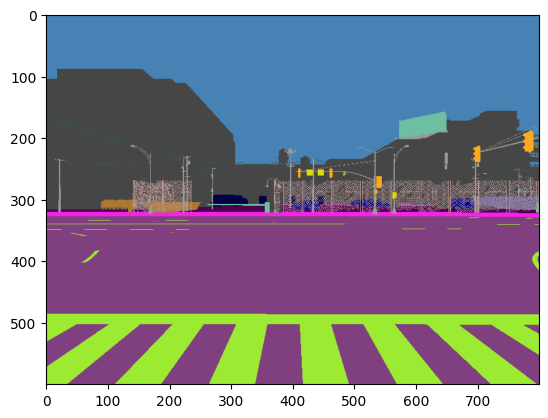

In [2]:
plt.imshow(sem_seg_array)
depth_array*1000

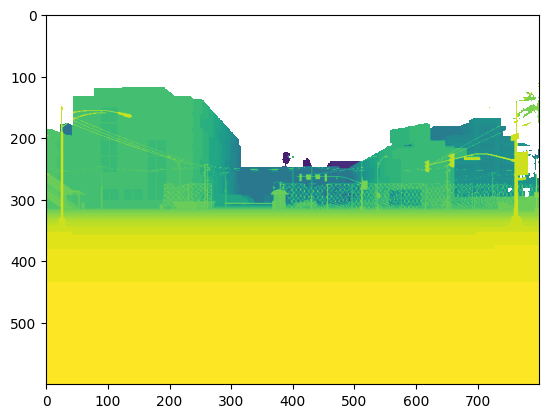

In [3]:
plt.imshow(depth_image)

In [2]:
data['sem_seg_camera1'].convert(carla.ColorConverter.CityScapesPalette)
array = np.frombuffer(data['sem_seg_camera1'].raw_data, dtype=np.dtype("uint8"))

In [6]:
array.shape[0]/600/800

4.0